#### Explore some edge detection algorithms

In [1]:
# imports libraries
import os
import sys
import glob
#import scipy.io.wavfile
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
#import importlib
import math
import pandas as pd

%matplotlib inline 

# Grabs the preprocessing and automatic_sync files
sys.path.append(os.path.join(os.pardir,'pythonCode'))
import preprocessing as pp
import automatic_sync as autoS
from __future__ import division

In [2]:
# reading the data

rawDataPath = os.path.join(os.pardir,'..','rawAudio')
files = glob.glob(os.path.join(rawDataPath,'*.wav'))
names = []
        
for name in files:
    fileName = os.path.basename(name).split(".")[0]
    names.append(fileName)

# Determines which cameras will be selected (['Bents'],['Camera Location'],['Motion #'])

filt = (None,None,['18']) # Selects the bent 1 cameras during motion 18

# Applies filter to camera names and returns only selected subset names
audioFiles = pp.getKeys(names,filt);

# Reads the .wav files from the list generted by getKeys
(names,cDataset) = pp.readWAV(rawDataPath,audioFiles);

Opening GP_B1_NL_18 ...
Opening GP_B1_NU_18 ...
Opening GP_B1_SL_18 ...
Opening GP_B1_SU_18 ...
Opening GP_B2_SL_18 ...
Opening GP_B2_SU_18 ...
Opening GP_B3_NL_18 ...
Opening GP_B3_NU_18 ...
Opening GP_B3_SL_18 ...
Opening GP_B3_SU_18 ...


In [3]:
## syncing the dataset
sDataset = autoS.sync_dataset(cDataset,names)
print(autoS.find_offset(sDataset,names[0],names[1:]))

{'GP_B2_SL_18': 82180, 'GP_B3_SU_18': 2607, 'GP_B3_NL_18': 4337, 'GP_B1_SL_18': 157, 'GP_B3_NU_18': 3475, 'GP_B2_SU_18': 85198, 'GP_B3_SL_18': 3256, 'GP_B1_NL_18': 0, 'GP_B1_NU_18': 116, 'GP_B1_SU_18': 535}


(1025, 2954)

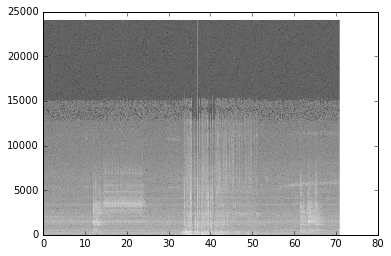

In [4]:
## Setting parameters for the spectrogram

NFFT = 2048       # the length of the windowing segments
Fs = int(48000)
# Pxx, freqs, bins, im = plt.specgram(data[:,0], NFFT=NFFT, Fs=Fs, noverlap=900,cmap=plt.cm.gist_heat)
ts = np.array(sDataset['GP_B1_NU_18'][:,1],dtype = 'float64')
Pxx, freq, bins, im = plt.specgram(ts,NFFT = NFFT,Fs = Fs,noverlap = 900,mode = 'psd',cmap = 'gray')#,cmap = plt.cm.gist_heat)
np.max(ts)
Pxx.shape

#### Find Sobel Edges 

-414578.39116230723

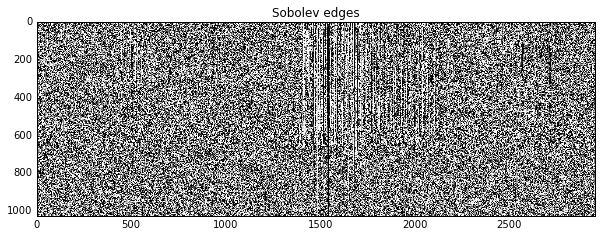

In [5]:
# Find Sobel Edges 

# without smoothing

from skimage import filters
edges = filters.sobel_v(Pxx[:,])
plt.figure(figsize = (10,6))
np.max(Pxx)
#np.min(Pxx)
plt.imshow(edges>0.,cmap = 'gray')
plt.title('Sobolev edges')
np.max(edges)
np.min(edges)

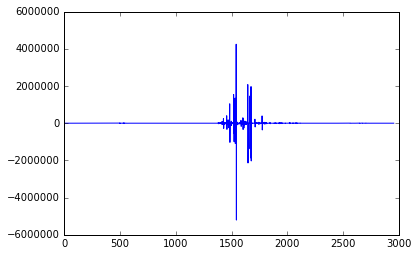

In [6]:
# sum at each location
plt.plot(np.sum(edges, axis = 0))

In [7]:
# the magic number
np.sum(np.sum(edges, axis = 0)>200000)

23

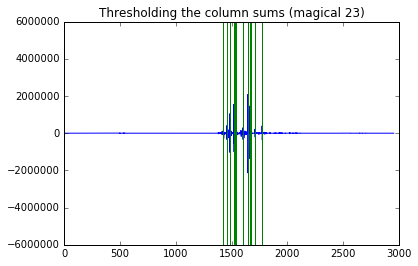

In [8]:
colSums = np.sum(edges, axis = 0)

# print(colSums)
x_position, = np.where(colSums>200000)

#print(type(x_position))
#plt.axvline(x_position[0:2])
plt.plot(colSums)


fig = [plt.axvline(_x, linewidth=1, color='g') for _x in x_position]
plt.title('Thresholding the column sums (magical 23)')

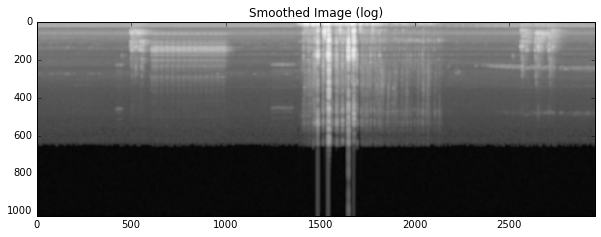

In [9]:
# Find edges with smoothing
Pxx_smoothed = filters.gaussian_filter(Pxx,5)
plt.figure(figsize = (10,6))
plt.imshow(np.log(Pxx_smoothed),cmap = 'gray')
plt.title('Smoothed Image (log)')

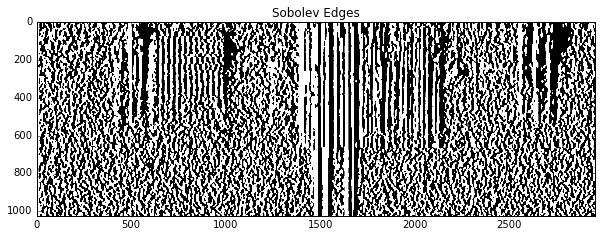

In [10]:
edges = filters.sobel_v(Pxx_smoothed[:,:])
plt.figure(figsize = (10,6))
plt.imshow(Pxx_smoothed)
plt.imshow(edges>0.,cmap = 'gray')
plt.title('Sobolev Edges')

#### Find Canny Edges

False

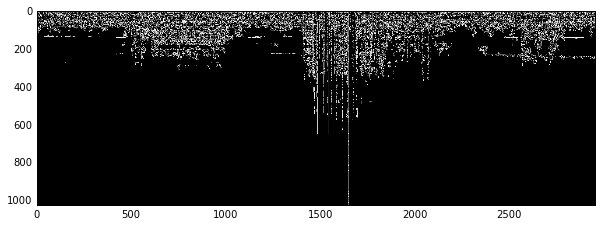

In [11]:
# Find Canny Edges

# without smoothing

from skimage import feature

edges = feature.canny(Pxx,0.1,0.001,5)
plt.figure(figsize = (10,6))
plt.imshow(Pxx,aspect = 'auto',cmap = 'gray')
np.max(Pxx)
#np.min(Pxx)
plt.imshow(edges>0.,cmap = 'gray')
np.max(edges)
np.min(edges)

#### Find Edges using Hough Transform

In [12]:
# Hough Transform
from skimage.transform import hough_line,hough_line_peaks,probabilistic_hough_line
im = Pxx/np.max(Pxx)
im = np.log(Pxx)/np.max(Pxx)
im = feature.canny(Pxx, 0.1,0.001,20)


h, theta, d = hough_line(im.T, theta = np.linspace(np.pi/2 - 0.01, np.pi/2 + 0.01, 180))

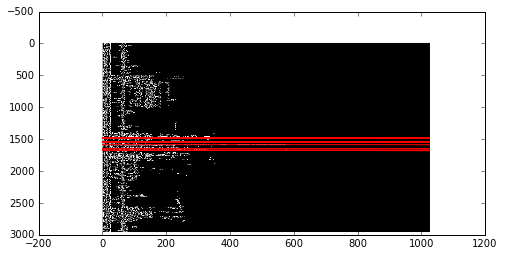

In [13]:
fig, ax3 = plt.subplots(1, 1, figsize=(8,4))
ax3.imshow((im.T), cmap=plt.cm.gray,aspect = 'auto')
rows, cols = im.T.shape
for h, angle, dist in zip(*hough_line_peaks(h, theta, d, threshold=10, min_distance = 5, num_peaks = 24)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - cols * np.cos(angle)) / np.sin(angle)
    ax3.plot((0, cols), (y0, y1), '-r')

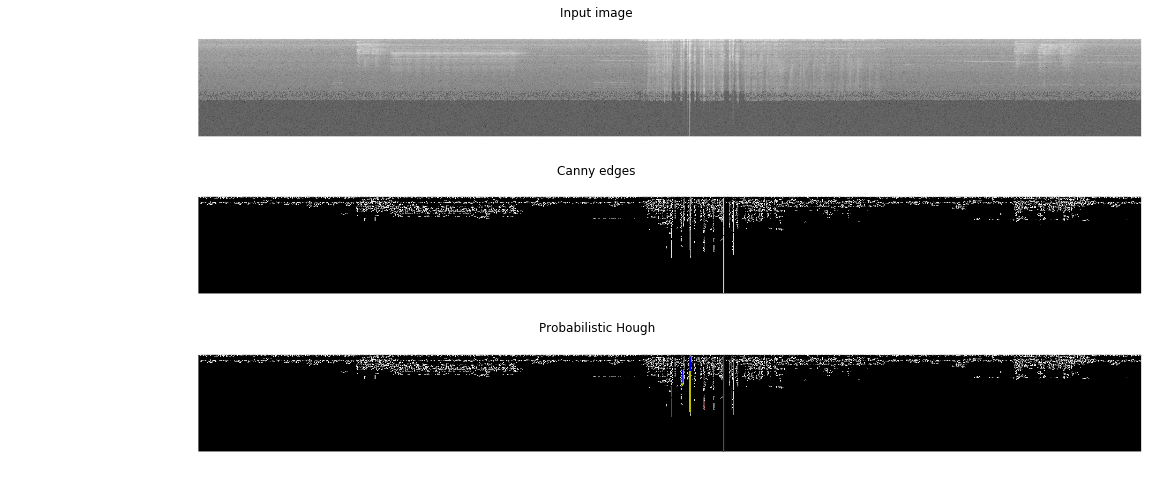

In [14]:
# Line finding, using the Probabilistic Hough Transform

image = Pxx
edges = feature.canny(image, 0.1,0.001,20)
lines = probabilistic_hough_line(edges, threshold=10, line_length=100,
                                 line_gap=3, theta = np.linspace(0.05,-0.05 , 180))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,8), sharex=True, sharey=True)

ax1.imshow(np.log(image), cmap=plt.cm.gray,aspect = 'auto')
ax1.set_title('Input image')
ax1.set_axis_off()
ax1.set_adjustable('box-forced')

ax2.imshow(edges, cmap=plt.cm.gray,aspect = 'auto')
ax2.set_title('Canny edges')
ax2.set_axis_off()
ax2.set_adjustable('box-forced')

ax3.imshow(edges,aspect = 'auto',cmap = 'gray')

for line in lines:
    p0, p1 = line
    ax3.plot((p0[0], p1[0]), (p0[1], p1[1]))

ax3.set_title('Probabilistic Hough')
ax3.set_axis_off()
ax3.set_adjustable('box-forced')
plt.show()

In [15]:
# extract the x coordinates of the lines
x_position = [line[0][0] for line in lines] 

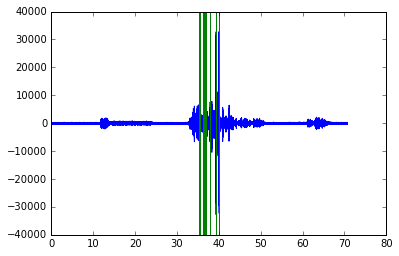

In [16]:
plt.plot(np.arange(len(ts))/48000,ts)
times = bins[np.array(np.array(x_position))]
fig = [plt.axvline(_x, linewidth=1, color='g') for _x in times]